# Importing & Splitting the dataset to test, train, validation sets

In [1]:
# import splitfolders

In [2]:
# input_folder = "dataset"
# output_folder = "processed_data"
# splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.8,.1,.1))

In [3]:
# help(splitfolders.ratio)

# Importing required packages

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing

In [5]:
img_height, img_width = (64,64)
batch_size = 32

train_data_dir = r"processed_data\train"
valid_data_dir = r"processed_data\val"
test_data_dir = r"processed_data\test"

In [6]:
train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.4) # set as training data

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

Found 709910 images belonging to 2 classes.
Found 50679 images belonging to 2 classes.
Found 33765 images belonging to 2 classes.


In [7]:
x, y = test_generator.next()
x.shape

(1, 64, 64, 3)

# Modeling and Fitting

In [8]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4) (x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator, validation_data=valid_generator, epochs = 8)

Epoch 1/8
22185/22185 [==============================] - 1605s 72ms/step - loss: 0.1437 - accuracy: 0.9479 - val_loss: 1.2007 - val_accuracy: 0.5614
Epoch 2/8
22185/22185 [==============================] - 1372s 62ms/step - loss: 0.0862 - accuracy: 0.9743 - val_loss: 2.5527 - val_accuracy: 0.5722
Epoch 3/8
22185/22185 [==============================] - 1346s 61ms/step - loss: 0.0721 - accuracy: 0.9799 - val_loss: 2.2518 - val_accuracy: 0.6404
Epoch 4/8
22185/22185 [==============================] - 1774s 80ms/step - loss: 0.0665 - accuracy: 0.9829 - val_loss: 2.5101 - val_accuracy: 0.6018
Epoch 5/8
22185/22185 [==============================] - 1304s 59ms/step - loss: 0.0622 - accuracy: 0.9847 - val_loss: 1.6961 - val_accuracy: 0.6050
Epoch 6/8
22185/22185 [==============================] - 1291s 58ms/step - loss: 0.0609 - accuracy: 0.9854 - val_loss: 2.4920 - val_accuracy: 0.6083
Epoch 7/8
22185/22185 [==============================] - 1294s 58ms/step - loss: 0.0600 - accuracy: 0.9856

# Evaluation

In [9]:
model.save('model/anomality_detection.h5')

C:\Users\Jamith\anaconda3\envs\anodet\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest Accuracy:', test_acc)

33765/33765 - 254s - loss: 0.7401 - accuracy: 0.7849

Test Accuracy: 0.7848955988883972


# Testing

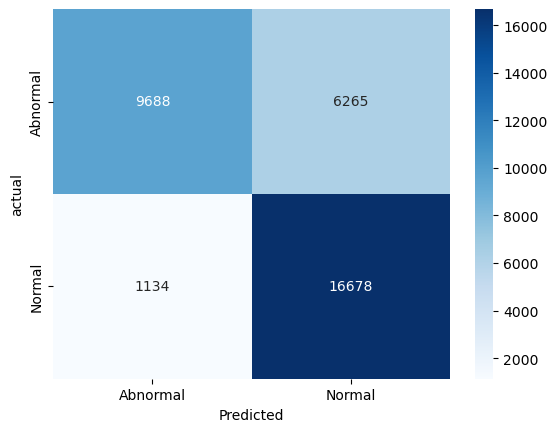

test accuracy : 78.08677624759366


In [11]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('model/anomality_detection.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()
print('test accuracy : {}'.format(np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100))